# Load datasets

In [6]:
import numpy as np
import pandas as pd

CLASSES = ["Bull", "Bear"]
LABEL_BULL = CLASSES.index("Bull")
LABEL_BEAR = CLASSES.index("Bear")

datasets = np.load("datasets.npz")
x_train, y_train = datasets["x_train"], datasets["y_train"]
x_val, y_val = datasets["x_val"], datasets["y_val"]
x_test, y_test = datasets["x_test"], datasets["y_test"]

label_distribution = pd.DataFrame([
                                {"Dataset": "train",
                                    "Bull": np.count_nonzero(y_train == LABEL_BULL),
                                    "Bear": np.count_nonzero(y_train == LABEL_BEAR)},
                                {"Dataset": "val",
                                    "Bull": np.count_nonzero(y_val == LABEL_BULL),
                                    "Bear": np.count_nonzero(y_val == LABEL_BEAR)},
                                {"Dataset": "test",
                                    "Bull": np.count_nonzero(y_test == LABEL_BEAR),
                                    "Bear": np.count_nonzero(y_test == LABEL_BEAR),}])

label_distribution

,Dataset,Bull,Bear
0,train,799,838
1,val,242,225
2,test,109,109


# Construct model

In [9]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

def inception_model(input_tensor):
    bottleneck = Conv1D(filters=32, kernel_size=1, padding="same", activation=None,
                        use_bias=False)(input_tensor)
    conv3 = Conv1D(filters=32, kernel_size=3, padding="same", activation=None,
                   use_bias=False)(input_tensor)
    conv5 = Conv1D(filters=32, kernel_size=5, padding="same", activation=None,
                   use_bias=False)(input_tensor)
    conv7 = Conv1D(filters=32, kernel_size=7, padding="same", activation=None,
                   use_bias=False)(input_tensor)
    mp = MaxPooling1D(pool_size=3, strides=1, padding="same")(input_tensor)
    mp_bottleneck = Conv1D(filters=32, kernel_size=1, padding="same", activation=None,
                           use_bias=False)(mp)
    
    x = Concatenate(axis=-1)([conv3, conv5, conv7, mp_bottleneck])
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def shortcut_layer(input_tensor1, input_tensor2):
    shortcut = Conv1D(filters=input_tensor2.shape[-1], kernel_size=1, padding="same", activation=None,
                      use_bias=False)(input_tensor1)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, input_tensor2])
    x = Activation("relu")(x)
    return x

# build model
n_time_steps = x_train.shape[1]
n_features = x_train.shape[2]

input_layer = Input(shape=(n_time_steps, n_features))
x = input_layer
input_residual = input_layer
for i in range(6):
    x = inception_model(x)

    if i % 3 == 2:
        x = shortcut_layer(input_residual, x)
        input_residual = x

x = GlobalAveragePooling1D()(x)
output_layer = Dense(len(CLASSES), activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 100, 5)    │          0 │ input_layer_2[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 100, 32)   │        480 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 100, 32)   │        800 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 100, 32)   │      1,120 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 100, 32)   │        160 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100, 128)  │          0 │ conv1d_6[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_7[0][0],   │
│                     │                   │            │ conv1d_8[0][0],   │
│                     │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 128)  │        512 │ concatenate_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 100, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 100, 128)  │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 100, 32)   │     12,288 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 100, 32)   │     20,480 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 100, 32)   │     28,672 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 100, 32)   │      4,096 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 100, 128)  │          0 │ conv1d_11[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_12[0][0],  │
│                     │                   │            │ conv1d_13[0][0],  │
│                     │                   │            │ conv1d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ concatenate_2[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 100, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 100, 128)  │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                 

 Total params: 351,618 (1.34 MB)

 Trainable params: 349,570 (1.33 MB)

 Non-trainable params: 2,048 (8.00 KB)

# Train model

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.utils import np_utils

model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model_checkpoint = ModelCheckpoint(filepath="best_model.keras", monitor="val_loss", save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)
callbacks = [model_checkpoint, early_stopping]

train_history = model.fit(
    x_train,
    np_utils.to_categorical(y_train),
    validation_data = (x_val, np_utils.to_categorical(y_val)),
    batch_size = 2048,
    epochs = 1000,
    callbacks=[callbacks])

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.5119 - loss: 1.2395 - val_accuracy: 0.4818 - val_loss: 3.6320
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5076 - loss: 1.0043 - val_accuracy: 0.4818 - val_loss: 4.3006
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5119 - loss: 0.7584 - val_accuracy: 0.4818 - val_loss: 3.6068
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4869 - loss: 0.7114 - val_accuracy: 0.4818 - val_loss: 2.2204
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4948 - loss: 0.7040 - val_accuracy: 0.4797 - val_loss: 1.9060
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5052 - loss: 0.7127 - val_accuracy: 0.4754 - val_loss: 2.1577
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4881 - loss: 0.7005 - val_accuracy: 0.4711 - val_loss: 2.0398
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4991 - loss: 0.7014 - val_accuracy: 0.4818 - val_loss: 1.357

In [11]:
import matplotlib.pyplot as plt
from matplotlib import style
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


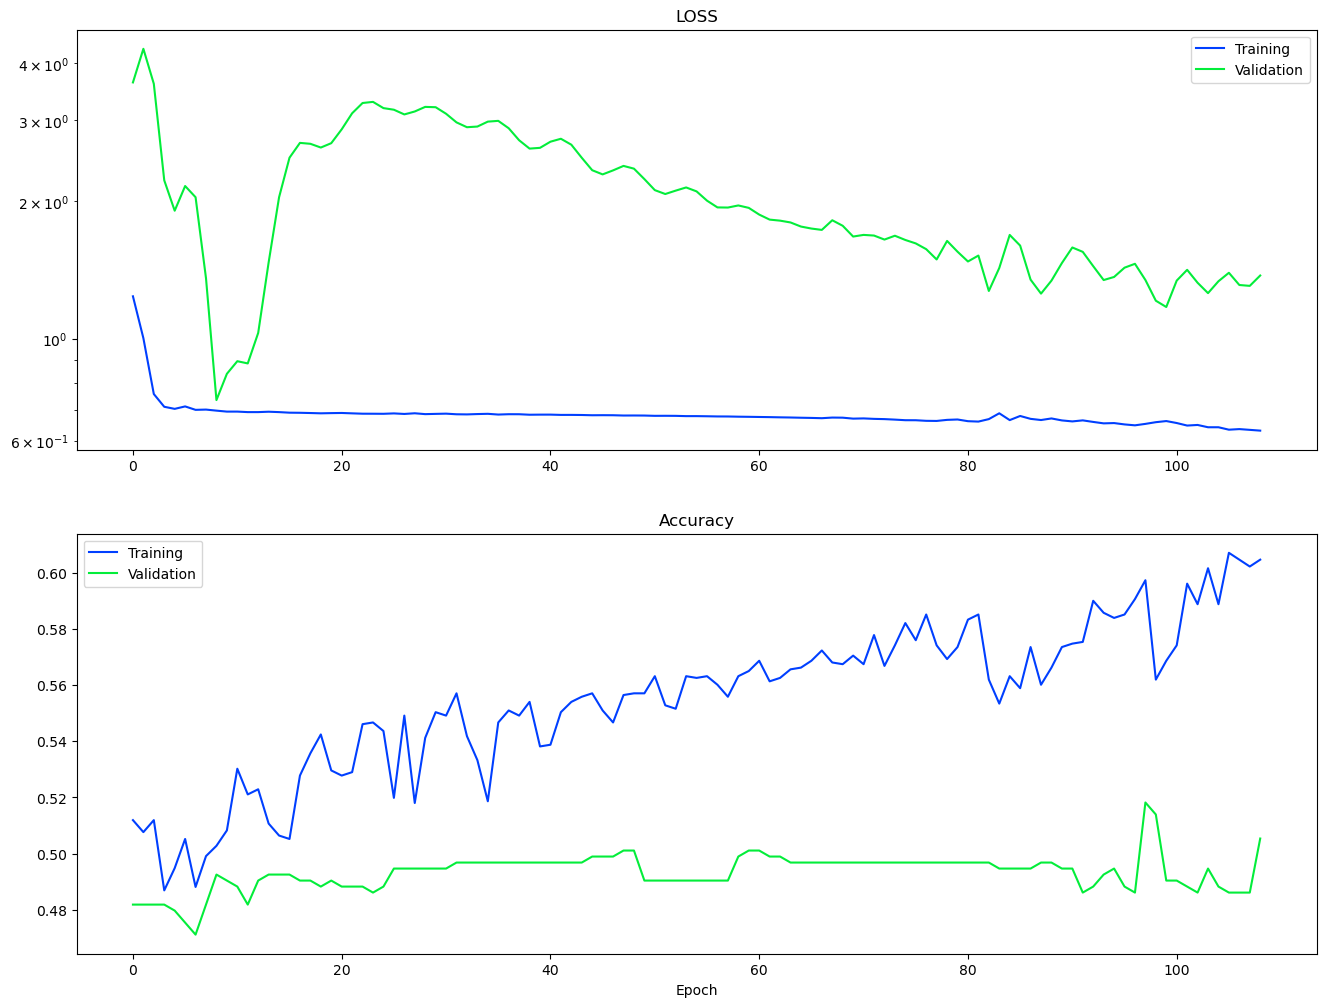

In [12]:
import matplotlib.pyplot as plt
import os

if not os.path.exists('images'):
    os.makedirs('images')

plt.style.use('seaborn-v0_8-bright')
fit, axes = plt.subplots(2, 1, figsize = (16, 12))

axes[0].set_title("LOSS")
axes[0].set_yscale("log")
axes[0].plot(train_history.history["loss"], label = "Training")
axes[0].plot(train_history.history["val_loss"], label = "Validation")
axes[0].legend()


axes[1].set_title("Accuracy")
axes[1].plot(train_history.history["accuracy"], label = "Training")
axes[1].plot(train_history.history["val_accuracy"], label = "Validation")
axes[1].set_xlabel("Epoch")
axes[1].legend()

# save plot
plt.figure(1)
plt.savefig('images/training_history.png')

# Evaluate model

In [13]:
from keras.utils import to_categorical
model.evaluate(x_test, to_categorical(y_test))

from tensorflow.math import argmax, confusion_matrix

y_pred_prob = model.predict(x_test)
y_pred = argmax(y_pred_prob, axis = -1)
cm = confusion_matrix(y_test, y_pred, num_classes = len(CLASSES)).numpy()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2374 - loss: 1.3983   
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


Text(33.22222222222222, 0.5, 'Label')

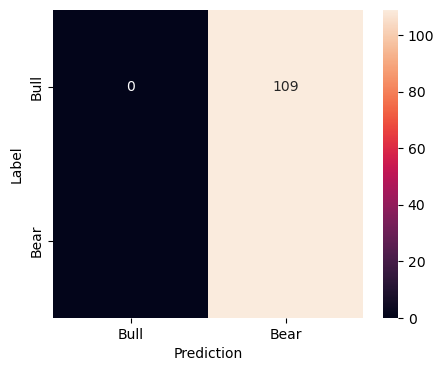

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 4))
sns.heatmap(cm, xticklabels=  CLASSES, yticklabels = CLASSES, annot=True, fmt = 'g')

plt.xlabel("Prediction")
plt.ylabel("Label")

In [15]:
n_bull_pred = cm[LABEL_BULL, LABEL_BULL] + cm[LABEL_BEAR, LABEL_BULL]
n_bull_true_pos = cm[LABEL_BULL, LABEL_BULL]
bull_accuracy = n_bull_true_pos / n_bull_pred if n_bull_pred > 0 else 0

n_bear_pred = cm[LABEL_BULL, LABEL_BEAR] + cm[LABEL_BEAR, LABEL_BEAR]
n_bear_true_pos = cm[LABEL_BEAR, LABEL_BEAR]
bear_accuracy = n_bear_true_pos / n_bear_pred if n_bear_pred > 0 else 0

n_total_pred = n_bull_pred + n_bear_pred
n_total_true_pos = n_bull_true_pos + n_bear_true_pos
total_accuracy = n_total_true_pos / n_total_pred if n_total_pred > 0 else 0

pd.DataFrame([{"Prediction": "Bull", "Accuracy": bull_accuracy},
              {"Prediction": "Bear", "Accuracy": bear_accuracy},
              {"Prediction": "Total", "Accuracy": total_accuracy}
              ])

,Prediction,Accuracy
0,Bull,0.0
1,Bear,0.5
2,Total,0.5


# Refference
[InceptionTime: Finding AlexNet for Time Series Classification](https://arxiv.org/pdf/1909.04939)